In [127]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

           Date        Open        High         Low       Close   Adj Close   
0    2022-07-27  263.809998  275.926666  261.790009  274.820007  274.820007  \
1    2022-07-28  280.066681  283.299988  272.799988  280.899994  280.899994   
2    2022-07-29  280.700012  298.320007  279.100006  297.149994  297.149994   
3    2022-08-01  301.276672  311.876678  295.000000  297.276672  297.276672   
4    2022-08-02  294.003326  307.833344  292.666656  300.586670  300.586670   
..          ...         ...         ...         ...         ...         ...   
246  2023-07-20  279.559998  280.929993  261.200012  262.899994  262.899994   
247  2023-07-21  268.000000  268.000000  255.800003  260.019989  260.019989   
248  2023-07-24  255.850006  269.850006  254.119995  269.059998  269.059998   
249  2023-07-25  272.380005  272.899994  265.000000  265.279999  265.279999   
250  2023-07-26  263.250000  268.040009  261.750000  264.350006  264.350006   

        Volume  
0     88110000  
1     84723000  


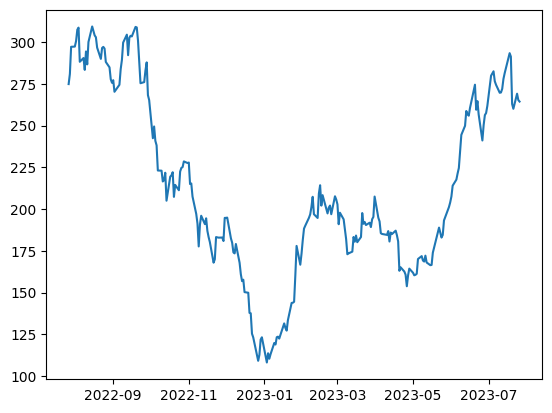

In [129]:
StockDat = pd.read_csv('TSLA (1).csv')
print(StockDat)
## We Generally Care about the Closing Data, Volume, High, Low Doesnt Really Matter ##

StockDat = StockDat[['Date','Close']]
print(StockDat)

# StockDat is our Subsetted Data that we will Now be forcasting on #

StockDat['Date'] = pd.to_datetime(StockDat['Date'])
plt.plot(StockDat['Date'],StockDat['Close'])

In the context of stock forecasting, an LSTM model operates on the principle of historical dependency. It assumes that the closing stock price of today is influenced by the closing prices of previous days. This model, a type of recurrent neural network, is designed to recognize and learn from patterns over time, making it a valuable tool for time series prediction. 

In [130]:
## Lets Take our Data Now and Prepare it for LSTM ##

def PrepData(StockDat,n_steps):
    StockDat = dc(StockDat)

    StockDat.set_index('Date', inplace = True)

    for i in range(1,n_steps+1):
        StockDat[f'Close(t-{i})']= StockDat["Close"].shift(i)
    StockDat.dropna(inplace=True)
    return StockDat
lookback = 7 
StockShiftedDat = PrepData(StockDat,lookback)
StockShiftedDat


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2022-08-05,288.170013,308.633331,307.396667,300.586670,297.276672,297.149994,280.899994,274.820007
2022-08-08,290.423340,288.170013,308.633331,307.396667,300.586670,297.276672,297.149994,280.899994
2022-08-09,283.333344,290.423340,288.170013,308.633331,307.396667,300.586670,297.276672,297.149994
2022-08-10,294.356659,283.333344,290.423340,288.170013,308.633331,307.396667,300.586670,297.276672
2022-08-11,286.630005,294.356659,283.333344,290.423340,288.170013,308.633331,307.396667,300.586670
...,...,...,...,...,...,...,...,...
2023-07-20,262.899994,291.260010,293.339996,290.380005,281.380005,277.899994,271.989990,269.790009
2023-07-21,260.019989,262.899994,291.260010,293.339996,290.380005,281.380005,277.899994,271.989990
2023-07-24,269.059998,260.019989,262.899994,291.260010,293.339996,290.380005,281.380005,277.899994


We've formatted our data to include historical stock prices, as the LSTM model uses this information to predict future prices. We've set a lookback period of 7 days, meaning the model will consider the closing prices of the past 7 days to predict the next day's closing price. This is achieved by shifting the 'Close' column in our DataFrame for each day in the lookback period.

In [131]:
NpShiftedStock = StockShiftedDat.to_numpy()
NpShiftedStock

Scaler = MinMaxScaler(feature_range=(-1,1))
NpShiftedStock = Scaler.fit_transform(NpShiftedStock)
NpShiftedStock

array([[0.7897824 , 0.99317487, 0.98088321, ..., 0.87903775, 0.71752299,
        0.65709176],
       [0.81217905, 0.7897824 , 0.99317487, ..., 0.88029684, 0.87903775,
        0.71752299],
       [0.74170896, 0.81217905, 0.7897824 , ..., 0.91319614, 0.88029684,
        0.87903775],
       ...,
       [0.5998409 , 0.50998891, 0.53861434, ..., 0.81174832, 0.722294  ,
        0.68770488],
       [0.56227009, 0.5998409 , 0.50998891, ..., 0.84116877, 0.81174832,
        0.722294  ],
       [0.55302655, 0.56227009, 0.5998409 , ..., 0.82049502, 0.84116877,
        0.81174832]])

Features like closing price, volume, and others can have different ranges. For example, closing prices might range from tens to hundreds, while volume might be in the millions. If we don't scale these features, the model might give more importance to features with larger values, which can lead to suboptimal predictions. In addition, LSTM models, like many other neural networks, use activation functions like the sigmoid or tanh that work best with inputs that are close to 0

In [132]:
# Separating the features and the target variable
X = NpShiftedStock[:,1:]
Y = NpShiftedStock[:, 0]

X.shape, Y.shape
X= dc(np.flip(X,axis=1))
X

array([[0.65709176, 0.71752299, 0.87903775, ..., 0.91319614, 0.98088321,
        0.99317487],
       [0.71752299, 0.87903775, 0.88029684, ..., 0.98088321, 0.99317487,
        0.7897824 ],
       [0.87903775, 0.88029684, 0.91319614, ..., 0.99317487, 0.7897824 ,
        0.81217905],
       ...,
       [0.68770488, 0.722294  , 0.81174832, ..., 0.82049502, 0.53861434,
        0.50998891],
       [0.722294  , 0.81174832, 0.84116877, ..., 0.53861434, 0.50998891,
        0.5998409 ],
       [0.81174832, 0.84116877, 0.82049502, ..., 0.50998891, 0.5998409 ,
        0.56227009]])

This section of code separates the features (X) and the target variable (Y) from the prepared data, NpShiftedStock. The features are all columns except the first one. The target is the first column. Then, it reverses the order of the feature columns and outputs the features.

In [133]:
split_index = int(len(X)*0.95)
split_index

TrainX = X[:split_index]
TestX = X[split_index:]

TrainY = Y[:split_index]
TestY = Y[split_index:]

TrainX = TrainX.reshape((-1, lookback , 1 ))
TestX = TestX.reshape((-1, lookback, 1))

TrainY = TrainY.reshape((-1 , 1))
TestY = TestY.reshape((-1, 1))

### Lets just Wrap this Stuff in Pytorch Tensor ###

TestX = torch.tensor(TestX).float()
TrainX = torch.tensor(TrainX).float()
TrainY = torch.tensor(TrainY).float()
TestY = torch.tensor(TestY).float()

This part of the code separates the dataset into training and testing sets, reshapes these sets to be compatible with the LSTM model, and finally wraps the data in PyTorch tensors.

The reshape function is used to convert our training and testing data into the three-dimensional format needed by LSTM models. For features, the new shape is (-1, lookback, 1), where -1 allows the shape to be automatically calculated. For the target variable, we reshape it to (-1, 1), meaning that we want n rows and 1 column.

In [134]:
## Turning this Into A custom Class so wwe can use a Data Set in TensorFlow ##

class TimeSeriesData(Dataset):
    def __init__(self,X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

Train_Data = TimeSeriesData(TrainX, TrainY)
Test_Data = TimeSeriesData(TestX, TestY)

This section of the code defines a custom class TimeSeriesData for the time series dataset. This class, which is a subclass of the Dataset class from the PyTorch library, makes it easier to handle and manipulate the data for training and testing in the context of machine learning.

The lines Train_Data = TimeSeriesData(TrainX, TrainY) and Test_Data = TimeSeriesData(TestX, TestY) create instances of the TimeSeriesData class for the training and testing sets. These instances can be used directly for training and testing machine learning models in PyTorch.

In [135]:
print(type(TrainX))
print(len(TrainX))

print(type(TrainY))
print(len(TrainY))

print(type(TestX))
print(len(TestX))

print(type(TestY))
print(len(TestY))


<class 'torch.Tensor'>
231
<class 'torch.Tensor'>
231
<class 'torch.Tensor'>
13
<class 'torch.Tensor'>
13


In [136]:
## We srap the DataSet in Data Loader to Get our Batches 
batch_size = 16 

TrainLoader = DataLoader(Train_Data, batch_size= batch_size, shuffle=True)
TestLoader = DataLoader(Test_Data, batch_size=batch_size,shuffle=False)

We utilize PyTorch's DataLoader to generate batches of the time series data for both the training and testing datasets. This approach allows for efficient iteration over the data during model training and evaluation.

In [137]:
## Lets Visualive what We have been doing so Far ## 
for _, batch in enumerate(TrainLoader):
    BatchX, BatchY = batch[0].to(device), batch[1].to(device)
    print(BatchX.shape, BatchY.shape)
    break 

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [138]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                             batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_stacked_layers, 
                             batch_first=True)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm1(x, (h0, c0))
        out, _ = self.lstm2(out)
        out = F.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out

model = LSTM(1, 4, 2)
model.to(device)

# Changing the optimizer to SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


The primary objective here is to define the structure of the Long Short-Term Memory (LSTM) model that will be used for time series prediction. This model will be trained to learn from the past stock data and make future predictions.

In this LSTM model, nn.LSTM is the LSTM layer and nn.Linear is the fully connected layer. The forward method is the forward pass of the model, where input data is passed through each layer of the model.

model = LSTM(1, 4, 2) creates an instance of the LSTM model with an input size of 1, hidden size of 4, and 2 stacked layers.

model.to(device) transfers the model to GPU if available. This is done to speed up computations.

Finally, torch.optim.SGD(model.parameters(), lr=0.01) sets the optimizer for training the model. The optimizer is responsible for updating the model's parameters (weights and biases) during training. The learning rate is set to 0.01.

In [139]:

def EpochOneT():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    RunLoss = 0.0 

    for batch_index, batch in enumerate (TrainLoader):
        BatchX, BatchY = batch[0].to(device), batch[1].to(device)

        Output = model(BatchX)
        loss = LossFunc(Output, BatchY)
        RunLoss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = RunLoss/100 
            print('Batch{0}, loss: {1:.3f})'.format(batch_index+1,
                                                    avg_loss_across_batches))
            RunLoss = 0.0 
print(0)



0


Each epoch is one full pass through the entire training dataset. The model's weights are updated with the goal of minimizing the loss function, which measures the difference between the model's predictions and the actual values.

The function loops through the training dataset batch by batch, performs a forward pass of the model, computes the loss, performs a backward pass (gradient computation), and then updates the model's parameters.

In [140]:
def EpochOneVal():
    model.train(False)
    Runloss = 0.0 

    for batch_index, batch in enumerate(TestLoader):
        BatchX, BatchY = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(BatchX)
            loss = LossFunc(output,BatchY)
            Runloss += loss.item()

    avg_loss_across_batches  = Runloss/ len (TestLoader)

    print('Validation Loss {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************')
    print()
    return avg_loss_across_batches

During validation, the model's performance is assessed on a separate dataset (the validation dataset) that the model has not seen during training. This helps check for overfitting and gauge how well the model generalizes to unseen data.

The code defines a function for one validation epoch. The function loops through the validation dataset batch by batch, performs a forward pass of the model, and computes the loss. Unlike during training, t

In [141]:
LearnRate = 0.001
NumEpoch = 100
LossFunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LearnRate)

In this section, the learning rate is set to 0.001, which determines the step size at each iteration while moving toward a minimum of a loss function. The number of epochs, which are full passes through the entire training dataset, is set to 100. The loss function is set to mean squared error (MSE), which is a common loss function for regression problems. Lastly, the optimizer is set to Adam, which is an extension of stochastic gradient descent and is generally a good choice for training deep learning models.

In [142]:
# The patience is the number of epochs to wait to see if the validation loss improves
patience = 20
# best_val_loss will hold the best validation loss achieved so far
best_val_loss = np.inf
# patience_counter will keep track of how many epochs have passed since the validation loss improved
patience_counter = 0

for epoch in range(NumEpoch):
    EpochOneT()
    val_loss = EpochOneVal()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print("Stopping training due to early stopping")
        break


Epoch: 1
Validation Loss 0.468
***************************************

Epoch: 2


Validation Loss 0.462
***************************************

Epoch: 3
Validation Loss 0.458
***************************************

Epoch: 4
Validation Loss 0.458
***************************************

Epoch: 5
Validation Loss 0.457
***************************************

Epoch: 6
Validation Loss 0.463
***************************************

Epoch: 7
Validation Loss 0.460
***************************************

Epoch: 8
Validation Loss 0.454
***************************************

Epoch: 9
Validation Loss 0.458
***************************************

Epoch: 10
Validation Loss 0.449
***************************************

Epoch: 11
Validation Loss 0.432
***************************************

Epoch: 12
Validation Loss 0.399
***************************************

Epoch: 13
Validation Loss 0.358
***************************************

Epoch: 14
Validation Loss 0.341
***************************************

Epoch: 15
Validation Loss 0.326
************************************

This practice helps prevent overfitting by stopping the training process when the model isn't learning anymore, saving both time and computational resources.

The code initiates a training loop that lasts for a predetermined number of epochs (100). For each epoch, the model is trained, and the validation loss is computed. If the validation loss improves (i.e., decreases), the 'best_val_loss' variable is updated, and the 'patience_counter' is reset. If the validation loss does not improve, the 'patience_counter' increases by 1. If the 'patience_counter' exceeds the 'patience' limit (20 in this case), the training stops prematurely.

In [143]:
for epoch in range(NumEpoch):
    EpochOneT()
    EpochOneVal()
with torch.no_grad():
    predicted = model(TrainX.to(device)).to('cpu').numpy()

Epoch: 1
Validation Loss 0.014
***************************************

Epoch: 2
Validation Loss 0.014
***************************************

Epoch: 3
Validation Loss 0.014
***************************************

Epoch: 4
Validation Loss 0.015
***************************************

Epoch: 5
Validation Loss 0.014
***************************************

Epoch: 6
Validation Loss 0.015
***************************************

Epoch: 7
Validation Loss 0.015
***************************************

Epoch: 8
Validation Loss 0.015
***************************************

Epoch: 9
Validation Loss 0.015
***************************************

Epoch: 10
Validation Loss 0.015
***************************************

Epoch: 11
Validation Loss 0.015
***************************************

Epoch: 12
Validation Loss 0.015
***************************************

Epoch: 13
Validation Loss 0.015
***************************************

Epoch: 14
Validation Loss 0.015
****************************

This process is fundamental to any machine learning task. After training a model, it's critical to generate predictions to evaluate the model's performance. In this case, we are generating predictions on the training data

In this code block, there are two main parts:

Training the Model:

The model is trained and validated over the range of the number of epochs (NumEpoch). At each epoch, the model is trained (EpochOneT()) and then validated (EpochOneVal()).

Predicting with the Model:

Once the model is fully trained, it is then used to generate predictions on the training dataset (TrainX). To make these predictions, with torch.no_grad(): is used to temporarily set all the requires_grad flag to false. This is because gradient is not needed for the inference step and this helps to reduce memory usage and speed up computations. The resulting predictions are then moved to CPU memory and converted to a NumPy array for easier manipulation.

The purpose of the next few blocks is to visualize and assess the performance of the trained LSTM model. It plots both the actual and predicted closing prices of the stock, first normalized, and then reverted back to original values. It shows how well the model's predictions match the actual stock prices for both training and testing datasets.

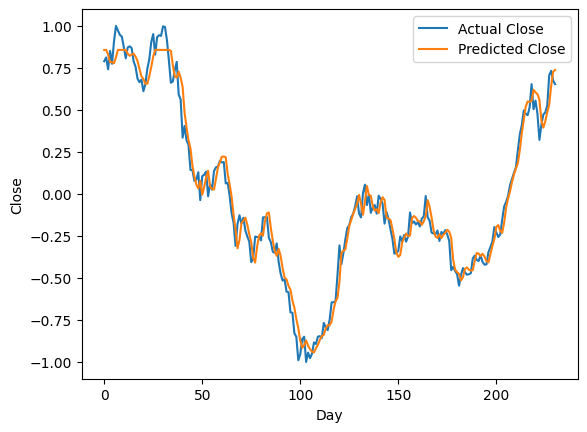

In [144]:
plt.plot(TrainY, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [145]:
from sklearn.preprocessing import MinMaxScaler

In [146]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your data
df = pd.read_csv('TSLA.csv')

# Create a scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the 'Close' column of your data
scaler.fit(df[['Close']])

# Now you can use this fitted scaler to inverse_transform your predictions
train_predictions = predicted.flatten()
dummies = np.zeros((TrainX.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)  # Use the fitted scaler

train_predictions = dummies[:, 0]
train_predictions


array([294.9506822 , 294.9506822 , 292.14038477, 287.63808357,
       287.6476485 , 286.94824496, 290.50397155, 294.9506822 ,
       294.9506822 , 294.9506822 , 294.9506822 , 294.9506822 ,
       292.75481931, 291.43856451, 292.16029422, 292.71737515,
       290.94928967, 288.28208245, 283.74338053, 279.09855282,
       277.45953098, 274.69701024, 274.75616291, 279.16232904,
       284.77004872, 290.92842672, 294.9506822 , 294.9506822 ,
       294.9506822 , 294.9506822 , 294.9506822 , 294.9506822 ,
       294.9506822 , 294.9506822 , 294.46181515, 285.85377668,
       279.11719694, 278.39865154, 281.9070512 , 278.27513497,
       272.85917572, 257.38976961, 248.53255114, 240.8892037 ,
       236.01809784, 225.73635791, 219.30135243, 214.29466439,
       211.95956126, 216.60729143, 208.20006261, 212.84045267,
       218.76787501, 222.57968395, 213.16244012, 211.78868777,
       211.32692036, 217.69282444, 224.4695949 , 227.65286477,
       230.99049888, 231.14655422, 230.65797501, 220.53

In [147]:
dummies = np.zeros((TrainX.shape[0], lookback+1))
dummies[:, 0] = TrainY.flatten()
dummies = scaler.inverse_transform(dummies)

NewTrainY = dc(dummies[:, 0])
NewTrainY

array([288.17001381, 290.42333826, 283.33334172, 294.35666084,
       286.63000553, 300.02999777, 309.320007  , 306.56332117,
       303.99667468, 302.86999747, 296.66665528, 289.9133324 ,
       296.45333627, 297.0966815 , 296.07000731, 288.08999819,
       284.82000825, 277.7000096 , 275.60998466, 277.16000164,
       270.20998895, 274.42001097, 283.7000115 , 289.26000846,
       299.67999316, 304.42001445, 292.13000427, 302.60998719,
       303.75000134, 303.35000721, 309.07000542, 308.73000951,
       300.79998992, 288.58999535, 275.32998697, 276.01000877,
       282.94000406, 287.8100005 , 268.20998832, 265.24999817,
       242.39999545, 249.44000247, 240.80999765, 238.1300052 ,
       223.07000674, 222.960007  , 216.50000001, 217.24000504,
       221.72000031, 204.99000492, 219.35000616, 220.19000223,
       222.03999232, 207.27999901, 214.44000191, 211.25000004,
       222.41999754, 224.63999914, 225.08999628, 228.52000396,
       227.53999256, 227.82000674, 214.97999601, 215.30

Inverse Transforming the Predictions:

1. Loading Data and Fitting Scaler: A MinMaxScaler is created and fitted to the 'Close' column of the original data. This is to align the scaling transformation with the actual data.

2. Flattening and Padding: The predictions are flattened and dummy variables are created to match the structure required for inverse transformation.

3. Inverse Transform: Using the fitted scaler, the inverse transformation is applied to revert the data back to its original scale.

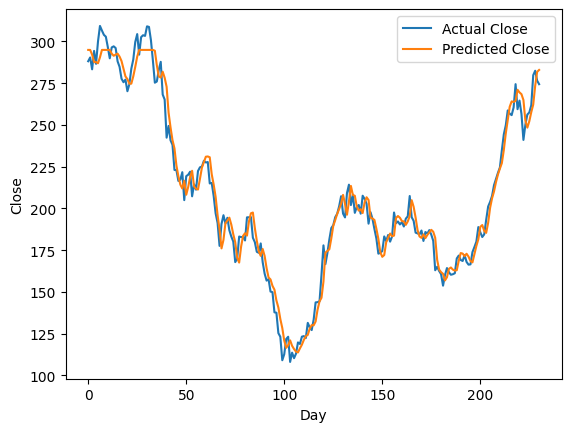

In [148]:
plt.plot(NewTrainY, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [149]:
TestPred = model(TestX.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((TestX.shape[0], lookback+1))
dummies[:, 0] = TestPred
dummies = scaler.inverse_transform(dummies)

TestPred= dc(dummies[:, 0])
TestPred


array([281.50016672, 277.90130498, 274.40190056, 272.84300828,
       275.82058111, 280.03088498, 285.50722025, 290.05684239,
       291.7363068 , 282.09031413, 270.24389499, 267.15680817,
       265.70919295])

In [150]:
dummies = np.zeros((TestX.shape[0], lookback+1))
dummies[:, 0] = TestY.flatten()
dummies = scaler.inverse_transform(dummies)

NewTestY = dc(dummies[:, 0])
NewTestY 


array([269.60998276, 269.7900074 , 271.98999011, 277.89999168,
       281.38000237, 290.38000521, 293.33999535, 291.26000909,
       262.89999293, 260.01998843, 269.05999608, 265.28000028,
       264.35000689])

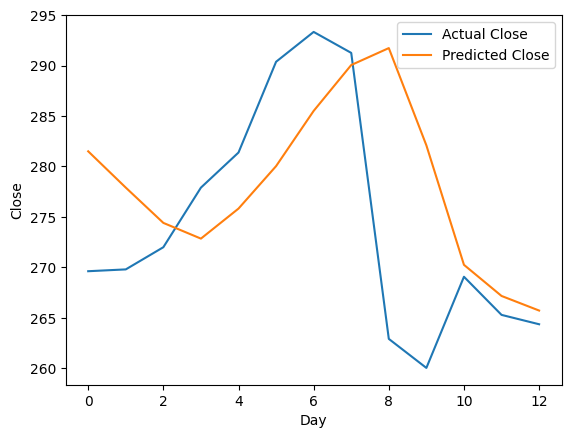

In [151]:
plt.plot(NewTestY, label='Actual Close')
plt.plot(TestPred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [152]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compute the error scores on train data
train_mae = mean_absolute_error(NewTrainY, train_predictions)
train_mse = mean_squared_error(NewTrainY, train_predictions)
train_rmse = np.sqrt(train_mse)

# Compute the error scores on test data
test_mae = mean_absolute_error(NewTestY, TestPred)
test_mse = mean_squared_error(NewTestY, TestPred)
test_rmse = np.sqrt(test_mse)

print(f'Training MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')


Training MAE: 6.50
Test MAE: 8.29
Training RMSE: 8.18
Test RMSE: 11.65


**Metrics Explanation:**

**Mean Absolute Error (MAE):** Represents the average absolute difference between the actual and predicted values. It is a measure of the accuracy of the prediction and does not consider the direction of the error. In this case:

Training MAE: 6.50
Test MAE: 8.29

These values suggest the average error in predicting the close price in the training and test datasets.

**Root Mean Squared Error (RMSE):** The square root of the mean squared error, representing the standard deviation of the prediction errors or residuals. It penalizes larger errors more heavily than the MAE:

Training RMSE: 8.18
Test RMSE: 11.65

Higher values of RMSE imply more variation in the error, and thus less reliability in the predictions.

In [153]:
from sklearn.linear_model import LinearRegression

# Prepare your data
# In this case, we'll use the 'Close' price from the previous day as our feature
X_train = TrainY[:-1]
y_train = TrainY[1:]
X_test = TestY[:-1]

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the 'Close' prices
pred = model.predict(X_test)

# You can now compare 'pred' with your test set


**Introduction to Validation Methods:** Linear Regression, ARIMA, and Why Benchmarking is Essential
When developing predictive models in finance or other quantitative fields, validation and benchmarking play vital roles. Let's dive into the underlying concepts and then relate them to the code provided.

**Linear Regression:**
Linear Regression is one of the simplest and most widely-used statistical techniques. It aims to model the relationship between a dependent variable and one or more independent variables by fitting a linear equation. In financial time series forecasting, it might be used to predict stock prices based on historical trends.

**ARIMA:**
The Autoregressive Integrated Moving Average (ARIMA) model is a popular time series forecasting method. ARIMA models the dependencies between an observation and its predecessors (autoregressive), the trend (integrated), and the error term (moving average). It's well-suited for univariate time series data that exhibit a trend or seasonality.

**The Importance of Testing and Benchmarking:**
Both Linear Regression and ARIMA serve as benchmarks in many projects, including stock price prediction. They represent tried-and-true methodologies against which more complex models like LSTMs can be compared. 

In [154]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

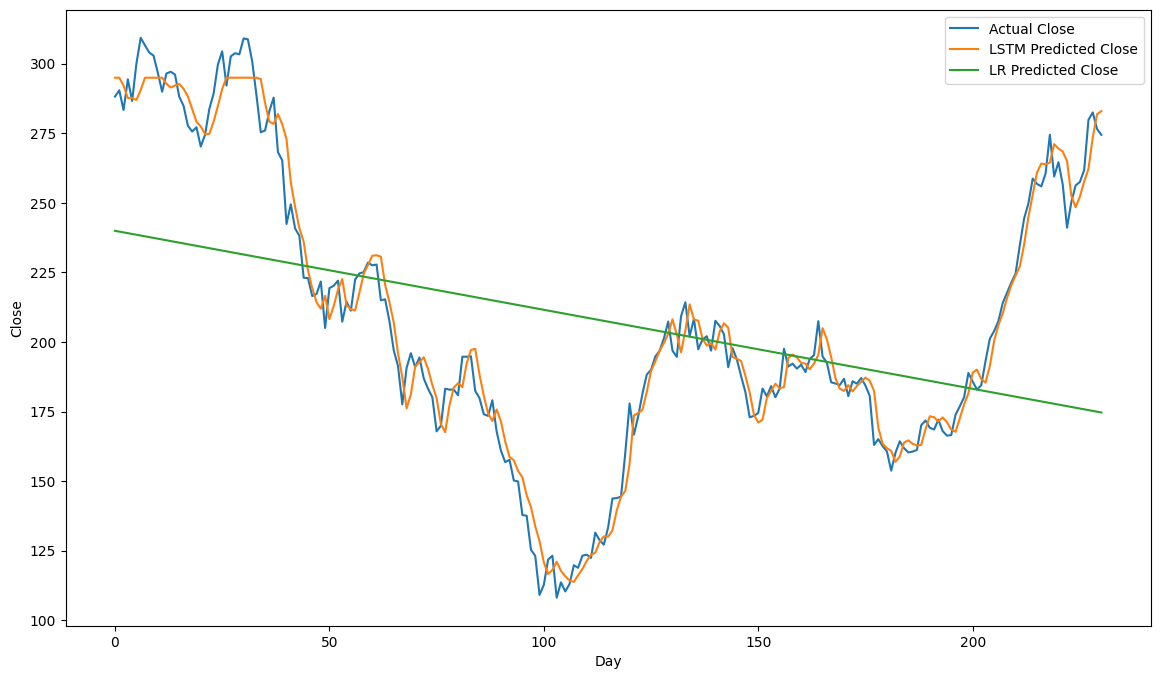

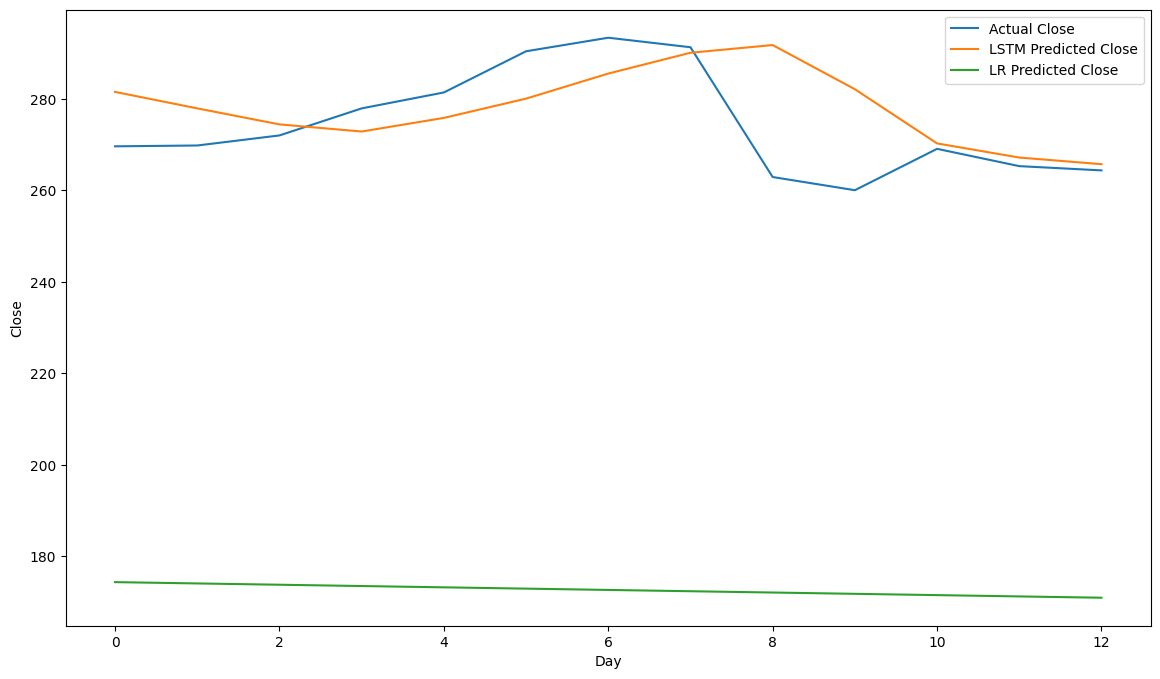

In [155]:
# Preparing data for linear regression
X_lr_train = np.array(range(len(TrainX))).reshape(-1,1)
y_lr_train = NewTrainY  # using actual closing prices for training
X_lr_test = np.array(range(len(TrainX), len(TrainX) + len(TestX))).reshape(-1,1)
y_lr_test = NewTestY  # using actual closing prices for testing

# Training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_lr_train, y_lr_train)

# Making predictions
lr_train_predictions = lr_model.predict(X_lr_train)
lr_test_predictions = lr_model.predict(X_lr_test)

# Plotting the results
plt.figure(figsize=(14,8))
plt.plot(NewTrainY, label='Actual Close')
plt.plot(train_predictions, label='LSTM Predicted Close')
plt.plot(lr_train_predictions, label='LR Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Plotting test predictions
plt.figure(figsize=(14,8))
plt.plot(NewTestY, label='Actual Close')
plt.plot(TestPred, label='LSTM Predicted Close')
plt.plot(lr_test_predictions, label='LR Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()



C:\Users\Apexr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


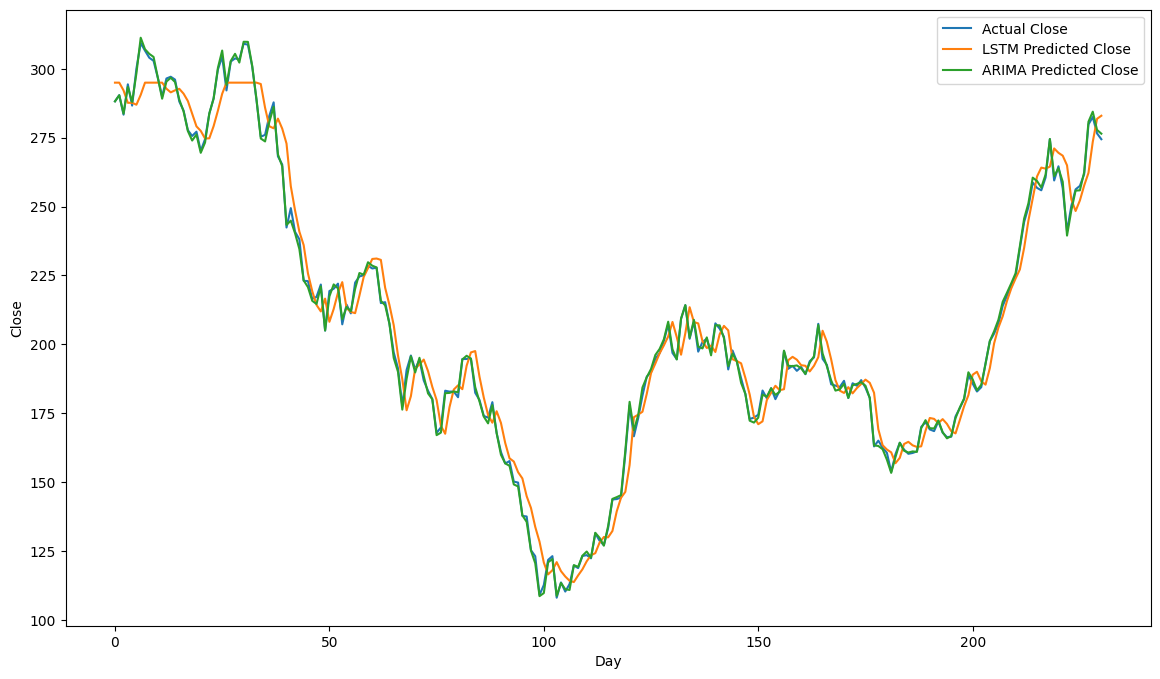

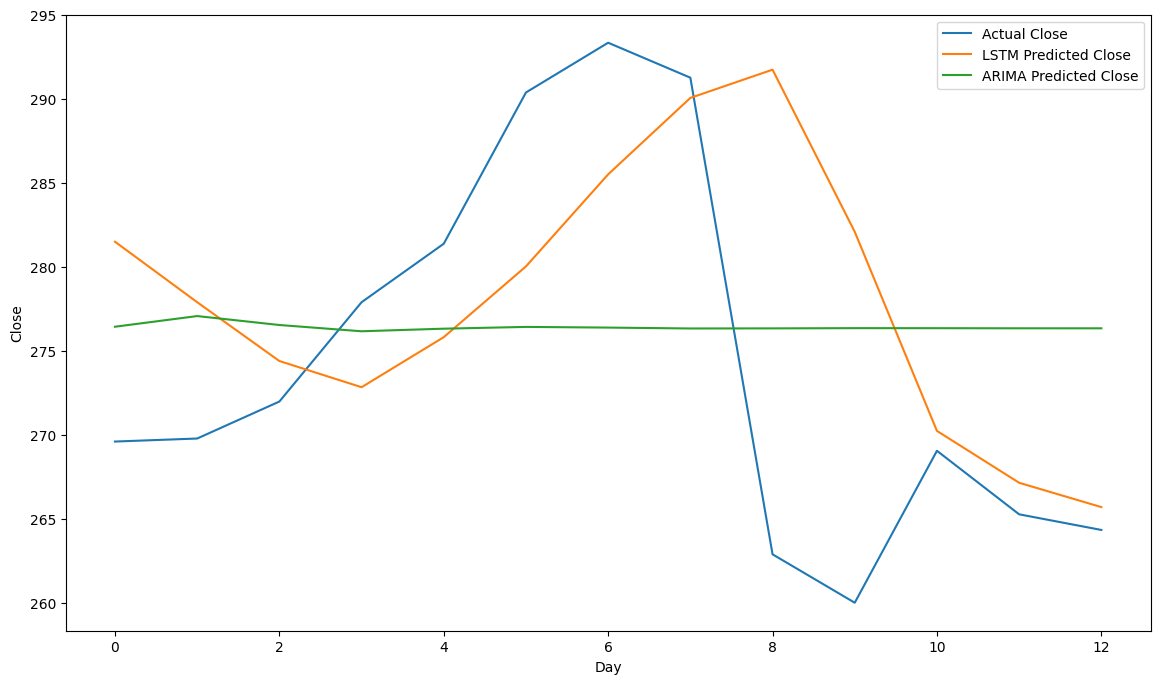

In [156]:

# Fit ARIMA model (p=5, d=1, q=0)
arima_model = ARIMA(NewTrainY, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Making predictions
arima_train_predictions = arima_model_fit.predict(start=1, end=len(NewTrainY), typ='levels')
arima_test_predictions = arima_model_fit.predict(start=len(NewTrainY), end=len(NewTrainY) + len(NewTestY)-1, typ='levels')

# Plotting train predictions
plt.figure(figsize=(14,8))
plt.plot(NewTrainY, label='Actual Close')
plt.plot(train_predictions, label='LSTM Predicted Close')
plt.plot(arima_train_predictions, label='ARIMA Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Plotting test predictions
plt.figure(figsize=(14,8))
plt.plot(NewTestY, label='Actual Close')
plt.plot(TestPred, label='LSTM Predicted Close')
plt.plot(arima_test_predictions, label='ARIMA Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [157]:


# For Linear Regression
train_mae_lr = mean_absolute_error(NewTrainY, lr_train_predictions)
train_mse_lr = mean_squared_error(NewTrainY, lr_train_predictions)
train_rmse_lr = np.sqrt(train_mse_lr)

test_mae_lr = mean_absolute_error(NewTestY, lr_test_predictions)
test_mse_lr = mean_squared_error(NewTestY, lr_test_predictions)
test_rmse_lr = np.sqrt(test_mse_lr)

# For LSTM
train_mae_lstm = mean_absolute_error(NewTrainY, train_predictions)
train_mse_lstm = mean_squared_error(NewTrainY, train_predictions)
train_rmse_lstm = np.sqrt(train_mse_lstm)

test_mae_lstm = mean_absolute_error(NewTestY, TestPred)
test_mse_lstm = mean_squared_error(NewTestY, TestPred)
test_rmse_lstm = np.sqrt(test_mse_lstm)

# For ARIMA
train_mae_arima = mean_absolute_error(NewTrainY[1:], arima_train_predictions[1:])  # Exclude first element because of differencing (d=1)
train_mse_arima = mean_squared_error(NewTrainY[1:], arima_train_predictions[1:])
train_rmse_arima = np.sqrt(train_mse_arima)

# In test set, if you have the same issue
test_mae_arima = mean_absolute_error(NewTestY[1:], arima_test_predictions[1:])
test_mse_arima = mean_squared_error(NewTestY[1:], arima_test_predictions[1:])
test_rmse_arima = np.sqrt(test_mse_arima)

# Print the metrics
print('Linear Regression:')
print(f'Train MAE: {train_mae_lr}, Train MSE: {train_mse_lr}, Train RMSE: {train_rmse_lr}')
print(f'Test MAE: {test_mae_lr}, Test MSE: {test_mse_lr}, Test RMSE: {test_rmse_lr}')

print('\nLSTM:')
print(f'Train MAE: {train_mae_lstm}, Train MSE: {train_mse_lstm}, Train RMSE: {train_rmse_lstm}')
print(f'Test MAE: {test_mae_lstm}, Test MSE: {test_mse_lstm}, Test RMSE: {test_rmse_lstm}')

print('\nARIMA:')
print(f'Train MAE: {train_mae_arima}, Train MSE: {train_mse_arima}, Train RMSE: {train_rmse_arima}')
print(f'Test MAE: {test_mae_arima}, Test MSE: {test_mse_arima}, Test RMSE: {test_rmse_arima}')

Linear Regression:
Train MAE: 37.134333484152876, Train MSE: 2288.7196203573662, Train RMSE: 47.84056459070447
Test MAE: 101.7297965673897, Test MSE: 10463.367566687308, Test RMSE: 102.29060351120873

LSTM:
Train MAE: 6.495465567233245, Train MSE: 66.96187184555912, Train RMSE: 8.183023392705113
Test MAE: 8.28779931686863, Test MSE: 135.75193322672627, Test RMSE: 11.651263160135311

ARIMA:
Train MAE: 0.976577828790158, Train MSE: 1.5232588882364155, Train RMSE: 1.2342037466465638
Test MAE: 10.38209827623964, Test MSE: 131.1818050007027, Test RMSE: 11.453462576911084


Interpretation and Insights:

1. **Linear Regression:**
Test Scores: MAE: 101.73, MSE: 10463.37, RMSE: 102.29
Interpretation: High error rates indicate that Linear Regression failed to capture the underlying trends effectively. Its simple linear approach may be inadequate for this time series problem.

2. **LSTM (Long Short-Term Memory):**
Test Scores: MAE: 8.29, MSE: 135.75, RMSE: 11.65
Interpretation: The LSTM model performed substantially better. Its lower error scores reflect a more nuanced understanding of the underlying patterns, likely owing to its ability to learn from sequential data.

3. **ARIMA (AutoRegressive Integrated Moving Average):**
Test Scores: MAE: 10.38, MSE: 131.18, RMSE: 11.45
Interpretation: The ARIMA model performed slightly worse than LSTM but much better than Linear Regression. It's a widely used method for time series forecasting but may not always capture complex non-linear relationships.

**Conclusion:**
The LSTM's superior performance on unseen data underscores its ability to generalize better and suggests it may be the preferable model for future predictions. The comparison between these methods demonstrates the importance of understanding the nature of the data and applying appropriate models and validation techniques. In a real-world scenario, one may also consider model complexity, training time, and other business constraints to select the best model.

In [158]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD as LegacySGD
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [159]:
# Prepare the LogReturn series
df['LogReturn'] = np.log(StockDat['Close']) - np.log(StockDat['Close'].shift(1))
df.dropna(inplace=True)

# Create a new dataframe with only 'LogReturn' column
data = df.filter(['LogReturn'])

# Convert dataframe to numpy array
dataset = data.values

# Get the number of rows to train the model on (say, 80% of the data)
training_data_len = int(np.ceil(len(dataset) * .8))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
   x_train.append(train_data[i-60:i, 0])
   y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into 3-D array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data to 3-D array since LSTM model expect a 3-D array as input
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Convert y_test to binary
y_test = np.where(y_test > 0, 1, 0)



The goal of this code is to prepare the data for predicting whether the stock price will rise or fall based on log returns. It employs a Long Short-Term Memory (LSTM) neural network model, known for its capability to remember patterns over long sequences. Here's a walkthrough:

**Code Breakdown**
Calculate Log Returns: The code first calculates the log returns from the closing prices, allowing a focus on the rate of change rather than absolute values.

Create Training Data: A sequence of 60 previous log returns is used to predict the next log return. This creation of sequences helps in understanding temporal dependencies.
Create Testing Data: Similar to training data, it creates testing sequences to evaluate the model's performance.

Build LSTM Model: It constructs an LSTM model with two LSTM layers followed by Dense layers. The final layer has a sigmoid activation function, as the goal is binary classification (whether the price will go up or down).
Compile and Train: The model is compiled using SGD (Stochastic Gradient Descent) with momentum and then trained on the training data.

Epoch 1/5
140/140 [==============================] - 4s 14ms/step - loss: 0.0925
Epoch 2/5
140/140 [==============================] - 2s 14ms/step - loss: 0.0513
Epoch 3/5
140/140 [==============================] - 2s 14ms/step - loss: 0.0543
Epoch 4/5
140/140 [==============================] - 2s 15ms/step - loss: 0.0521
Epoch 5/5
2/2 [==============================] - 1s 7ms/step
Precision: 0.68
Recall: 1.0
AUC-ROC: 0.5


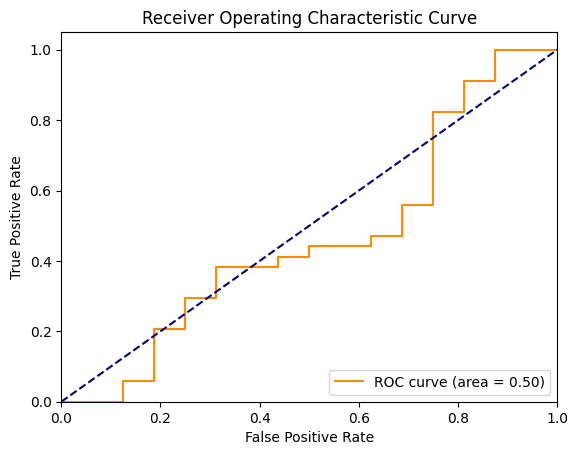

In [160]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with SGD optimizer
sgd = LegacySGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy')

# Train the model
model.fit(x_train, np.where(y_train > 0, 1, 0), batch_size=1, epochs=5)

# Get the models predicted price values
predictions = model.predict(x_test)

# Convert predictions to binary
binary_predictions = np.where(predictions > 0.5, 1, 0)

# Calculate precision, recall and AUC-ROC
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
auc_roc = roc_auc_score(y_test, binary_predictions)

print(f'Precision: {precision}\nRecall: {recall}\nAUC-ROC: {auc_roc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

Imagine standing in the bustling office of BlackRock, surrounded by seasoned professionals analyzing market data, making investment decisions, and striving to stay ahead of the curve. At this level, innovation is key, but so is practicality. Here's why:

**Predicting Closing Prices: A Common Path**
Most people, from independent traders to internet enthusiasts, have access to historical closing prices. Many are tempted to build models to predict these values. It's logical and straightforward, but here's where the trouble begins:

**Widespread Accessibility:** Since everyone can access this data, creating a predictive model for closing prices isn't truly innovative. It's a path well-trodden.

**Limited Practical Utility:** Predicting the exact closing price might be an exciting academic exercise, but in real-world trading, it's not particularly useful. The closing prices are subject to numerous influences and noise, and a misprediction can result in significant capital loss.

**Missing the Bigger Picture:** Closing price predictions don't provide insights into the market's underlying trends or direction. It's akin to focusing on individual trees while missing the forest's grandeur.

**Transitioning to Log Returns:** **A New Perspective**
In the BlackRock scenario, seasoned professionals aren't just looking for predictions; they want insights. This leads us to log returns:

**Why Log Returns?**: Log returns, rather than closing prices, focus on the rate of change. It's not about predicting a precise value but understanding the trend and magnitude of movement.

**Predicting Direction:** With log returns, the goal shifts from predicting exact prices to forecasting whether the price will go up or down. This can be a much more valuable tool for traders, as it aligns with practical trading strategies.

**More Robust and Insightful:** Log returns provide a more stable, noise-free perspective that resonates with financial wisdom and market understanding.

**The Leap Towards Trading Agents**
Imagine this predictive capability being fed into an intelligent trading agent:

**Enhanced Strategies:** By knowing whether a stock's price is likely to rise or fall, trading agents can position their trades more effectively.

**Potential for Increased Accuracy:** Integrating log returns with other models and factors can boost accuracy further, providing a more nuanced view of market dynamics.

**An Innovative Edge:** While others may still be fixated on predicting closing prices, this approach aligns more with what traders genuinely seek: strategic insights for intelligent decision-making.

**Conclusion**
In a world where everyone has access to the same data, simply predicting closing prices isn't enough. It's like trying to invent a new melody using the same old notes. But by focusing on log returns, we enter a new, more sophisticated realm of understanding, one that resonates with the real world of trading and finance. It's a tune that could make even the folks at BlackRock tap their feet, and one that brings us closer to the next big thing in trading innovation.